# Modèle EOLES

Traduction en python du modèle EOLES créé par Philippe Quirion.

Notebook pour simulation du modèle

- Import des données 
- Définition des paramètres autres (eta_in, eta_out, etc) 
- Création du modèle Pyomo pour optimiser la répartition du stockage quand les vre ne répondent pas à la demande
- Output: Génération heure par heure par chaque tecno dans un excel 
- Etat actuel: ne fonctionne pas, problèmes sur les contraintes -> toutes les valeurs de l'excel sont à 0. 

**Pour run:** soit le solveur cbc est installé sur jupyter et tout va bien / soit il est installé ailleurs (genre un terminal ubuntu par exemple) et ducoup faut download as .py et run à partir du terminal. 

In [ ]:
-fixed cost of MWh

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time
import sys
# Imports pour pyomo
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

import panel as pn 
from ipywidgets import interactive, interact_manual
import ipywidgets as widgets

#%matplotlib inline
pn.extension()


from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas


In [2]:
col = {"offshore" : '#1f4e79', "onshore" : '#548235' , "pv" : "#ffc000", "phs" : "#bdd7ee", "battery" : "#7030a0", "biogas" :"#843c0c", "methanation": "#7f6000", "gas": "grey", "lake": "#4169E1", "river" : "#09F1D3"}

In [3]:
tec = ["offshore","onshore","pv","river","lake","biogas","phs","battery","methanation"]
stor = ["phs","battery","methanation"]


## Import et Affichage des résultats de P.Quirion

## Coût des différentes technologies

In [4]:
scenarios = pd.read_csv("outputs/scenarios.csv", index_col="scen")
cost_decomposition = pd.read_csv("outputs/cost decomposition for all scenarios.csv", index_col="scen")

In [5]:
#scénario choisi 
scen = 157 
list(scenarios.iloc[scen][5:])

['central', 'central', 'central', 'central', 'central']

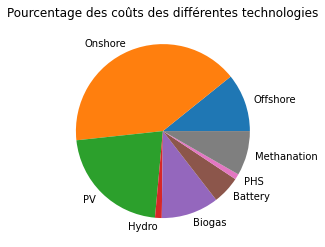

In [6]:
plt.figure()
plt.pie(list(map(lambda x: float(x[:-1]),list(cost_decomposition.iloc[scen]))), labels = ["Offshore","Onshore","PV","Hydro","Biogas","Battery","PHS","Methanation"])
plt.title("Pourcentage des coûts des différentes technologies")
plt.show()

### Résultats de l'optimisation 

In [7]:
#hourly_profile06 = pd.read_csv("outputs/with 2016 demand/hourly profiles with demand of 2016.csv", index_col = "hour")
#hourly_profile06.head()

In [8]:
scen2006 = pd.read_csv("outputs/real CF after internalization of LC/2006_LC_internalized.csv", index_col = "hour")
scen2006.columns = ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'gas', 'phs',
       'battery', 'methanation', 'Electricity demand', 'Storage phs', 'Storage battery', 'Storage methanation', 'Stored battery',
       'Stored phs', 'Stored methanation', 'elec_price', 'gas_price']
scen2006.head()

,offshore,onshore,pv,river,lake,biogas,gas,phs,battery,methanation,Electricity demand,Storage phs,Storage battery,Storage methanation,Stored battery,Stored phs,Stored methanation,elec_price,gas_price
hour,,,,,,,,,,,,,,,,,,,
0,10.93,40.80,0.0,1.27,0.0,0.0,0.0,0.00,0.0,0.0,28.69,-9.30,-7.35,-7.66,31.75,82.95,1813.37,0.0,0.0
1,0.00,42.09,0.0,1.30,0.0,0.0,0.0,0.00,0.0,0.0,31.21,-4.52,0.00,-7.66,38.37,91.78,1817.90,0.0,0.0
2,11.12,31.67,0.0,0.00,0.0,0.0,0.0,1.87,0.0,0.0,27.70,-9.30,0.00,-7.66,38.37,96.08,1822.42,0.0,0.0
3,0.00,43.18,0.0,1.12,0.0,0.0,0.0,0.00,0.0,0.0,27.99,-8.65,0.00,-7.66,38.37,102.84,1826.94,0.0,0.0
4,2.17,42.95,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,28.16,-9.30,0.00,-7.66,38.37,111.06,1831.46,0.0,0.0


In [9]:
# Sorties de l'opitimisation de P.Quirion
Volume_str_opti = pd.Series([180 ,92.32, 15244.42], index = stor)
S_opti = pd.Series([9.3,25.67, 8.52], index = stor)
Q_tec_opti = pd.Series([16.95, 99.22, 115, 7.5, 12.86,21.25, 9.3, 25.67, 21.25], index = tec)
Cost_opti = 24.24 #€

In [10]:
# Dashboard

def show(week,name):
    
    if name == "scen2006": 
        d = scen2006
        Volume = Volume_str_opti
        
    else :
        d = pd.read_csv(name+"/"+name+"_hourly_generation.csv", index_col = 0, squeeze = True)
        Volume = pd.read_csv(name+"/"+name+"_Volume.csv", index_col = 0, squeeze = True)
    
    
    
    tec_aux = tec
    
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = 168*(week-1)+np.arange(1,169)
    ymin, ymax = -45,130
    h_ratio = np.ones(len(stor)+1)
    h_ratio[0] = 2 # 1er subplot 2 fois plus grand
    fig, axs = plt.subplots(len(stor)+1, figsize = (15,15),gridspec_kw={'height_ratios':h_ratio})
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        sum_s += d["Storage " + i][h]
    for s in stor[::-1]:
        aux = "Storage " + s
        axs[0].fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs[0].fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs[0].plot(h, d["Electricity demand"][h], color = 'r' , label = "Demand",linewidth= 4)

    axs[0].vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    #axs[0].set_xlabel("Heure (h)")
    axs[0].set_ylabel("Production (GWh)")
    axs[0].set_ylim(ymin,ymax)
    #axs[0].set_xlim(h[0], h[-1]+70)
    axs[0].legend(loc ="upper right")
    axs[0].set_title("Semaine "+ str(week))
    

        
    for s in range(0,len(stor)):
        axs[s+1].fill_between(h, d["Stored " + stor[s]][h], color = col[stor[s]])
        axs[s+1].hlines(y=Volume[s], xmin = h[0], xmax = h[-1], label = "limit", color = 'red')
        axs[s+1].set_title("Stored " + str(stor[s]))
        axs[s+1].vlines(x=np.linspace(h[0],h[-1],8),ymin = 0, ymax = Volume[s]+10,colors="black",linestyle='dotted',linewidth=2)
        

## Choix de Q, S et VOLUME

In [11]:
phs_bounds = {"Q_lower":5.2,"Q_upper": 9.3, "S_lower":4.2, "S_upper":6.2, "Volume_lower":80.16, "Volume_upper":135.5}
vre_upper_bounds = {"onshore":120, "offshore": 66, "pv": 156.5}

In [12]:
# Choix intéractif des variables

V = widgets.Text(value='Volume de stockage (GWh)', disabled=True)
Volume_phs = widgets.FloatSlider(min=phs_bounds["Volume_lower"], max=phs_bounds["Volume_upper"], step=0.01, description='Volume phs',value = Volume_str_opti["phs"])
Volume_methanation = widgets.FloatSlider(min=0, max=Volume_str_opti["methanation"]*5, step=0.01, description='Volume methanation',value = Volume_str_opti["methanation"])
Volume_battery =  widgets.FloatSlider(min=0, max=Volume_str_opti["battery"]*5, step=0.01, description='Volume battery',value = Volume_str_opti["battery"])
  

Q = widgets.Text(value='Capcité installée (GW)', disabled=True)
Q_offshore= widgets.FloatSlider(min=0, max=vre_upper_bounds["offshore"], step=0.01, description='Q offshore',value = Q_tec_opti["offshore"])
Q_onshore= widgets.FloatSlider(min=0, max=vre_upper_bounds["onshore"], step=0.01, description='Q onshore',value = Q_tec_opti["onshore"])
Q_pv= widgets.FloatSlider(min=0, max=vre_upper_bounds["pv"], step=0.1, description='Q pv',value = Q_tec_opti["pv"])
Q_river= widgets.FloatSlider(min=0, max=Q_tec_opti["river"], step=0.01, description='Q river',value = Q_tec_opti["river"])
Q_lake= widgets.FloatSlider(min=0, max=Q_tec_opti["lake"], step=0.01, description='Q lake',value = Q_tec_opti["lake"])
Q_biogas= widgets.FloatSlider(min=0, max=Q_tec_opti["biogas"]*5, step=0.01, description='Q biogas',value = Q_tec_opti["biogas"])
Q_phs= widgets.FloatSlider(min=phs_bounds["Q_lower"], max=phs_bounds["Q_upper"], step=0.01, description='Q phs',value = Q_tec_opti["phs"])
Q_battery= widgets.FloatSlider(min=0, max=Q_tec_opti["battery"]*5, step=0.01, description='Q battery',value = Q_tec_opti["battery"])
Q_methanation= widgets.FloatSlider(min=0, max=Q_tec_opti["methanation"]*5, step=0.01, description='Q methanation',value = Q_tec_opti["methanation"])


S = widgets.Text(value='Capacité de charge (GW)', disabled=True)
S_phs= widgets.FloatSlider(min=phs_bounds["S_lower"], max=phs_bounds["S_upper"], step=0.01, description='S phs',value = S_opti["phs"])
S_methanation = widgets.FloatSlider(min=0, max=S_opti["methanation"]*5, step=0.01, description='S methanation',value = S_opti["methanation"])
warn = widgets.Textarea(value='      Attention ! \n      Volume > Q  et  Volume > S', disabled=True)

widgets.HBox([widgets.VBox([Q, Q_offshore, Q_onshore, Q_pv, Q_river, Q_lake,Q_biogas ,Q_phs,Q_battery,Q_methanation]),
widgets.VBox([V,Volume_phs,Volume_battery,Volume_methanation, warn]), widgets.VBox([S,S_methanation, S_phs])])


In [13]:
# Mise en forme des variables

Q_tec = [Q_offshore.value, Q_onshore.value, Q_pv.value, Q_river.value, Q_lake.value,Q_biogas.value ,Q_phs.value,Q_battery.value,Q_methanation.value]
Volume_str = [Volume_phs.value,Volume_methanation.value,Volume_battery.value]
S =  [Q_phs.value,S_methanation.value,Q_battery.value]

# Capacity in GW Q
Q_tec = pd.Series( Q_tec, index = tec)

    
# Energy volume of storage technology in GWh VOLUME
Volume_str =pd.Series(Volume_str, index = stor)

#Storage charging power S
S =pd.Series(S, index = stor)


print("Valeurs fixées : ")
print("--------- Q ---------")
print(Q_tec)
print("-------- VOLUME -------")
print(Volume_str)
print("--------- S ---------")
print(S)

Valeurs fixées : 
--------- Q ---------
offshore        16.95
onshore         99.22
pv             115.00
river            7.50
lake            12.86
biogas          21.25
phs              9.30
battery         25.67
methanation     21.25
dtype: float64
-------- VOLUME -------
phs              135.50
battery        15244.42
methanation       92.32
dtype: float64
--------- S ---------
phs             9.30
battery         8.52
methanation    25.67
dtype: float64


## Résultats constatés quant aux profils des années 2000-2006

**2000** :

- rough week 2 : necessary to use looots of methanation to compensate
- week 8 : lots of methanation taken away
- empty reserves week 14
- no stocking for a while from 14 to 30
- lots of storage from 30 to 50
- lots of lake from 49 - 50

**2001**
 
- very windy first week + week 6 + week 41 + 45
- rough week 3 & 5
- same : zero storage from 14 or only short-term storage
- huge production week 16, but zero storage
- small production week 19
- low storage week 24, 25
- methanation storage from week 30 to compensate for week 3 & 5

**2002**

- not lots of methanation week 1
- depletion of it all week 2
- wind week 4 6 8 43
- methanation storage from week 3 
- depletion mathanation week 7
- zero storage week 8, 11, 19, 20, 21, 26
- week 17 : enormous surplus but zero long-term storage
- no long-term storage from 17-36
- pretty bad 44, 46
- lake 49

**2003**

- rough week 6, 7
- no methanation week 9 - 35
- pretty chill year, sun wind, no big hoels to fill
- lake 48-52

**2004**

- lots of wind first weeks + methanation charging
- bad week 6, 7, 10, 45, 48, 49, 50
- recharging methanation 8,9
- no methanation week 10 - 21
- week 21-26 : methanation + phs storage
- week 21- storage
- veeery little wind this year, particularly week 32
- wind week 12
- sun week 17
- max charging methanation reached 44

**2005**

- lots of wind beginning of year, weeks 1, 2, 7, 36, 40
- bad week 5, 6, 8
- no methanation week 9
- quite little storage between 10 and 31
- restarting week 31 methanation storage
- wind week 43

**Bad weeks : usually high need for electricity, not particularly low production**

**Remarque**

- modèle un peu cheaté pcq des fois surpoduction, mais absence de stockage car pas de besoins sur les semaines d'après donc coûts minimisés alors que dans la vraie vie, on aurait stocké pour prévoir une éventuelle chute de vent, soleil etc
- for insatnt needs in terms of taking little from storage : phs + battery

## Création d'une année difficile pour voir les effets sur le coûts et le stockage

In [ ]:
load_factor2000 = pd.read_csv( "inputs/vre_profiles2000.csv", index_col=[0, 1], squeeze=True, header=None)
load_factor2001= pd.read_csv( "inputs/vre_profiles2001.csv", index_col=[0, 1], squeeze=True, header=None)
load_factor2002= pd.read_csv( "inputs/vre_profiles2002.csv", index_col=[0, 1], squeeze=True, header=None)
load_factor2003= pd.read_csv( "inputs/vre_profiles2003.csv", index_col=[0, 1], squeeze=True, header=None)
load_factor2004= pd.read_csv( "inputs/vre_profiles2004.csv", index_col=[0, 1], squeeze=True, header=None)
load_factor2005= pd.read_csv( "inputs/vre_profiles2005.csv", index_col=[0, 1], squeeze=True, header=None)

Ici, remplacer semaines où le stockage est vide par des semaines de production faible afin de voir l'influence sur le stockage et les moyens de production possibles hors VRE.  
Possibilité de voir l'influence d'une demande plus élevée en changeant le fichier demand_ademe par ex

In [ ]:
horrible_year=load_factor2000
horrible_year['offshore'][7*24*14:7*24*15]=load_factor2000['offshore'][7*24*3:7*24*4]#=np.zeros(7*24)
horrible_year['pv'][7*24*14:7*24*15]=load_factor2000['pv'][7*24*3:7*24*4]
horrible_year['onshore'][7*24*14:7*24*15]=load_factor2000['onshore'][7*24*3:7*24*4]
horrible_year['offshore'][7*24*15:7*24*16]=load_factor2000['offshore'][7*24*6:7*24*7]#=np.zeros(7*24)
horrible_year['pv'][7*24*15:7*24*16]=load_factor2000['pv'][7*24*6:7*24*7]
horrible_year['onshore'][7*24*15:7*24*16]=load_factor2000['onshore'][7*24*6:7*24*7]
#horrible_year2 = pd.DataFrame(horrible_year, columns = ['offshore','pv','onshore'])
horrible_year.to_csv('inputs/horrible_year.csv')

# Simulation du modèle

In [14]:
from modeles import modele
name = "simu_test"


simu1 = modele(Q_tec_opti, Volume_str_opti, S_opti)
simu1.load_param("inputs/")
simu1.run()

Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 


In [15]:
res = simu1.write_results('simu_opti_horrible_year')
simu1.cost().to_csv('simu_opti_horrible_year/costs.csv')

Ecriture des résultats ...


,hour,offshore,onshore,pv,river,lake,biogas,phs,battery,methanation,Storage phs,Storage battery,Storage methanation,Stored phs,Stored battery,Stored methanation,reserve phs,reserve battery,reserve lake,Electricity demand
0,0,7.80,19.64,0.0,1.27,0.00,0.0,0.00,0.0,0.0,-0.00,-0.0,-0.02,180.00,92.32,12477.42,0.0,7.82,0.0,28.69
1,1,7.70,20.67,0.0,1.30,0.00,0.0,1.55,0.0,0.0,-0.00,-0.0,-0.00,180.00,92.32,12477.42,0.0,7.85,0.0,31.21
2,2,7.53,21.28,0.0,1.11,0.00,0.0,0.00,0.0,0.0,-0.00,-0.0,-2.22,178.28,92.32,12477.42,0.0,7.81,0.0,27.70
3,3,7.56,22.12,0.0,1.12,0.00,0.0,0.00,0.0,0.0,-0.00,-0.0,-2.81,178.28,92.32,12478.73,0.0,7.81,0.0,27.99
4,4,7.67,22.92,0.0,1.21,0.00,0.0,0.00,0.0,0.0,-0.00,-0.0,-3.64,178.28,92.32,12480.39,0.0,7.82,0.0,28.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8755,6.86,41.05,0.0,2.79,12.86,0.0,0.00,0.0,0.0,-9.30,-7.0,-8.52,142.87,86.02,12452.28,0.0,7.93,0.0,38.61
8756,8756,5.60,37.93,0.0,2.72,12.86,0.0,0.00,0.0,0.0,-9.30,-0.0,-8.52,151.70,92.32,12457.31,0.0,7.94,0.0,39.34
8757,8757,4.28,33.65,0.0,2.45,12.86,0.0,0.00,0.0,0.0,-8.01,-0.0,-8.52,160.54,92.32,12462.33,0.0,7.91,0.0,36.71
8758,8758,3.26,29.34,0.0,2.24,12.86,0.0,0.00,0.0,0.0,-5.90,-0.0,-8.52,168.15,92.32,12467.36,0.0,7.87,0.0,33.29


**Notes persos**

Semaine pourrie en plus => plus de production lacs => coûts plus élevés (ordre de la dizaine de centime /mWh donc significatif qd même)

- simu_opti : toutes les tec, valeurs opti de Q, S, Volume
- simu_phs_x5_without_river_lake 

# Comparaison des simulations et outputs de l'article

In [16]:
noms_simu = ["scen2006", "simu_opti", "simu_phs_x5_without_river_lake","simu_opti_annee_2000","simu_opti_annee_2001",
             "simu_opti_annee_2002","simu_opti_annee_2003","simu_opti_annee_2004","simu_opti_annee_2005"
             ,"simu_opti_horrible_year"]


In [17]:
# Dashboard
interactive_plot = interact_manual(show, week=widgets.IntText(value = 1), name = noms_simu)
interactive_plot

interactive(children=(IntText(value=1, description='week'), Dropdown(description='name', options=('scen2006', …

<function __main__.show(week, name)>

## Etude des stocks + compréhension

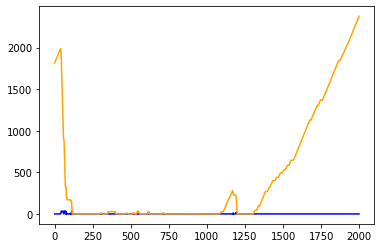

In [65]:
plt.plot(scen2006["methanation"][0:2000],color="blue")
plt.plot(scen2006["Stored methanation"][0:2000],color="orange")
plt.show()

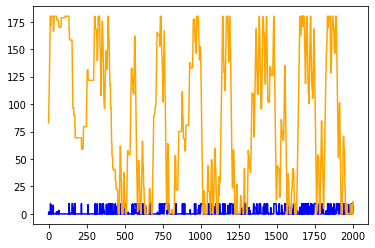

In [64]:
plt.plot(scen2006["phs"][0:2000],color="blue")
plt.plot(scen2006["Stored phs"][0:2000],color="orange")
plt.show()

## Comparaison des coûts totaux

In [18]:
print("Coûts", simu1.cost())

Coûts    COST (billion euros)  Cost per MWh produced (euros/MWh)
0             22.310002                          38.654951


In [19]:
Cost_opti 

24.24

In [20]:
print("Optimal cost for P. Quirion's model in 2006 (billion euros): 21.82")
print("Cost per MWh produced fro P. Quirion's model in 2006 : 51.65 ")

Optimal cost for P. Quirion's model in 2006 (billion euros): 21.82
Cost per MWh produced fro P. Quirion's model in 2006 : 51.65 


## Notes perso

- Différence entre stocké et stockage : stockage : éléctricité produite qui va aller dans el stockage
- Stocké : electicité déjà en stock


- Début d'année : moins de surplus => stock de méthanation utilisés et milieu d'année : beaucoup de surplus => stocks remplis
- Méthanation peu souvent voire jamais saturée
- Batterie très souvent saturée, de même pour phs

**Questions**

- Comment a t-on autant d'électricité en stock avec si peu de surplus total ?    
- A quoi correspond une telle capacité de stockage ?

#### Modèle P. Quirion

In [66]:
scen2006

,offshore,onshore,pv,river,lake,biogas,gas,phs,battery,methanation,Electricity demand,Storage phs,Storage battery,Storage methanation,Stored battery,Stored phs,Stored methanation,elec_price,gas_price
hour,,,,,,,,,,,,,,,,,,,
0,10.93,40.80,0.0,1.27,0.0,0.0,0.0,0.00,0.0,0.0,28.69,-9.30,-7.35,-7.66,31.75,82.95,1813.37,0.0,0.0
1,0.00,42.09,0.0,1.30,0.0,0.0,0.0,0.00,0.0,0.0,31.21,-4.52,0.00,-7.66,38.37,91.78,1817.90,0.0,0.0
2,11.12,31.67,0.0,0.00,0.0,0.0,0.0,1.87,0.0,0.0,27.70,-9.30,0.00,-7.66,38.37,96.08,1822.42,0.0,0.0
3,0.00,43.18,0.0,1.12,0.0,0.0,0.0,0.00,0.0,0.0,27.99,-8.65,0.00,-7.66,38.37,102.84,1826.94,0.0,0.0
4,2.17,42.95,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,28.16,-9.30,0.00,-7.66,38.37,111.06,1831.46,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.00,55.57,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,38.61,-9.30,0.00,-7.66,2.69,38.77,1790.77,0.0,0.0
8756,12.47,43.83,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,39.34,-9.30,0.00,-7.66,2.69,47.61,1795.29,0.0,0.0
8757,0.00,65.87,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,36.71,-9.30,-12.20,-7.66,2.69,56.44,1799.81,0.0,0.0


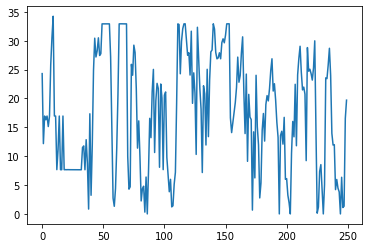

In [90]:
surplus=np.zeros(8760)
for i in range(0,8759):
    if surplus[i]>=(scen2006['Electricity demand'][i]-scen2006['offshore'][i]
                    -scen2006['onshore'][i]-scen2006['pv'][i]-scen2006['river'][i]-scen2006['lake'][i]
                    -scen2006['biogas'][i]-scen2006['gas'][i]-scen2006['phs'][i]-scen2006['battery'][i]
                    -scen2006['methanation'][i]) :
        surplus[i]=(scen2006['Electricity demand'][i]-scen2006['offshore'][i]
                    -scen2006['onshore'][i]-scen2006['pv'][i]-scen2006['river'][i]-scen2006['lake'][i]
                    -scen2006['biogas'][i]-scen2006['gas'][i]-scen2006['phs'][i]-scen2006['battery'][i]
                    -scen2006['methanation'][i])
#surplus=(scen2006['Electricity demand']-scen2006['offshore']
       #  -scen2006['onshore']-scen2006['pv']-scen2006['river']-scen2006['lake']
       #  -scen2006['biogas']-scen2006['gas']-scen2006['phs']-scen2006['battery']
        # -scen2006['methanation'])
        
plt.plot(-surplus[0:250])

In [91]:
sum(-surplus)

104854.53000000321

In [83]:
sum(scen2006['Stored methanation']+scen2006['Stored phs']+scen2006['Stored battery'])

61223101.48999988

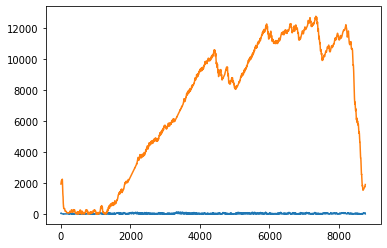

In [97]:
plt.plot(-surplus)
plt.plot(scen2006['Stored methanation']+scen2006['Stored phs']+scen2006['Stored battery'])

Ici, à creuser, mais on dirait que les stocks contiennent énormément d'énergie par rapport au surplus calculé : comment ont-ils été remplis ? 

#### Notre modèle 

In [86]:
simu_opti=res
simu_opti

,hour,offshore,onshore,pv,river,lake,biogas,phs,battery,methanation,Storage phs,Storage battery,Storage methanation,Stored phs,Stored battery,Stored methanation,reserve phs,reserve battery,reserve lake,Electricity demand
0,0,14.66,50.77,0.0,1.27,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-8.52,79.52,0.0,12877.46,0.0,7.82,0.00,28.69
1,1,14.92,52.38,0.0,1.30,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-8.52,79.52,0.0,12882.49,0.0,7.85,0.00,31.21
2,2,14.92,53.38,0.0,1.11,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-8.52,79.52,0.0,12887.51,0.0,7.81,0.00,27.70
3,3,14.80,53.73,0.0,1.12,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-8.52,79.52,0.0,12892.54,0.0,7.81,0.00,27.99
4,4,14.44,53.45,0.0,1.21,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-8.52,79.52,0.0,12897.57,0.0,7.82,0.00,28.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8755,16.59,80.95,0.0,2.79,0.0,0.0,0.0,0.0,0.0,-9.3,-0.0,-8.52,35.34,0.0,12852.32,0.0,0.00,7.93,38.61
8756,8756,16.72,81.31,0.0,2.72,0.0,0.0,0.0,0.0,0.0,-9.3,-0.0,-8.52,44.18,0.0,12857.35,0.0,0.00,7.94,39.34
8757,8757,16.79,81.97,0.0,2.45,0.0,0.0,0.0,0.0,0.0,-9.3,-0.0,-8.52,53.01,0.0,12862.38,0.0,0.00,7.91,36.71
8758,8758,16.80,81.88,0.0,2.24,0.0,0.0,0.0,0.0,0.0,-9.3,-0.0,-8.52,61.85,0.0,12867.40,0.0,0.00,7.87,33.29


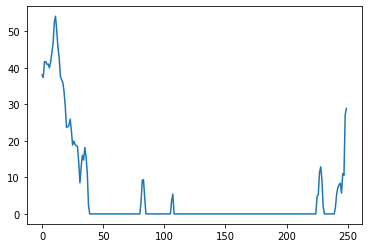

In [92]:
surplus=np.zeros(8760)
for i in range(0,8759):
    if surplus[i]>=(simu_opti['Electricity demand'][i]-simu_opti['offshore'][i]
                    -simu_opti['onshore'][i]-simu_opti['pv'][i]-simu_opti['river'][i]-simu_opti['lake'][i]
                    -simu_opti['biogas'][i]-simu_opti['phs'][i]-simu_opti['battery'][i]
                    -simu_opti['methanation'][i]) :
        surplus[i]=(simu_opti['Electricity demand'][i]-simu_opti['offshore'][i]
                    -simu_opti['onshore'][i]-simu_opti['pv'][i]-simu_opti['river'][i]-simu_opti['lake'][i]
                    -simu_opti['biogas'][i]-simu_opti['phs'][i]-simu_opti['battery'][i]
                    -simu_opti['methanation'][i])
#surplus=(scen2006['Electricity demand']-scen2006['offshore']
       #  -scen2006['onshore']-scen2006['pv']-scen2006['river']-scen2006['lake']
       #  -scen2006['biogas']-scen2006['gas']-scen2006['phs']-scen2006['battery']
        # -scen2006['methanation'])
        
plt.plot(-surplus[0:250])

In [93]:
sum(-surplus)

184196.20999999935

In [94]:
sum(simu_opti['Stored methanation']+simu_opti['Stored phs']+simu_opti['Stored battery'])

42514572.08999991

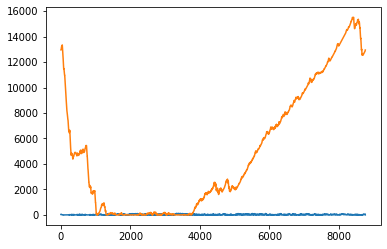

In [96]:
plt.plot(-surplus)
plt.plot(simu_opti['Stored methanation']+simu_opti['Stored phs']+simu_opti['Stored battery'])

Possibilités :

- Erreur de compréhension/interprétation de ma part
- Aucune contrainte de stockage comme étant différent de zéro au tout départ du modèle
- Différence d'unités entre stockage et surplus 
- Erreur sur les contraintes de stockage : remplissage aléatoire